# 분기고시가 예측가 산출 모델

## 변수 정의
### 1. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)
### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)
### 3. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


In [318]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 숫자 출력 조정
# 넘파이 부동소수점 출력 자리수 설정
np.set_printoptions(suppress = True, precision = 4)
# 판다스 부동소수점 출력 자리수 설정
pd.options.display.float_format = '{:.4f}'.format
# 데이터프레임 모든 필드 출력
pd.set_option("display.max_columns", None)

# 그래프 글꼴 크기 설정
plt.rcParams["font.size"] = 14
# 난수 시드
random_seed = 123
pd.set_option('display.max_rows', 500)

In [319]:
df = pd.read_csv('steel_prices_data.csv', sep=',')
#날짜,분기고시가만 따로 분리
df_raw = df[['date', '분기고시가']]
#결측값 확인
df.isnull().sum()

date               105
분기고시가                0
weightA            105
priceUSA_TAIWAN    105
priceJP            105
priceCN            105
importPriceUSA     105
importPriceJP      105
stock              105
USD_KR             105
JPY_KR             105
dtype: int64

df_all.head()

In [320]:
df = df.dropna()

#날짜형으로 변환
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200


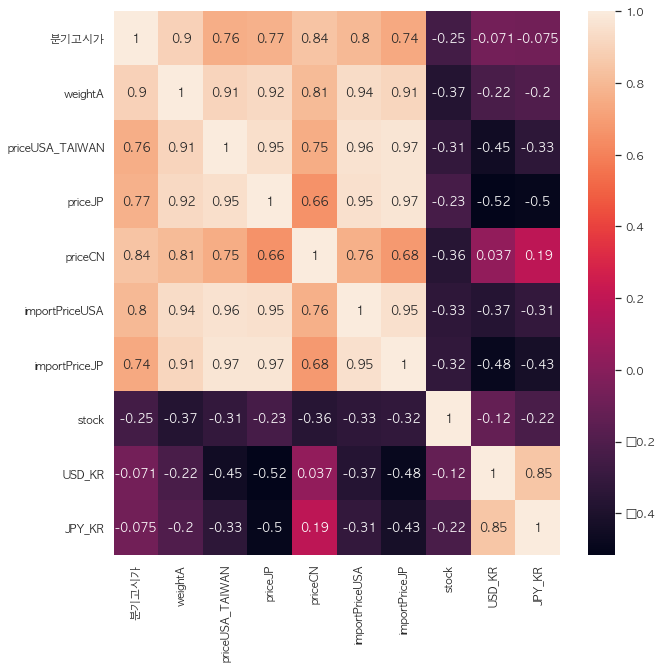

In [321]:
# 상관관계 분석  
import seaborn as sns
# 상관관계 행렬 
df_corr = df.corr()
#Drawing HEAT MAP
fig = plt.figure (figsize=(10,10))
sns.set(font_scale=1, font="AppleGothic")
sns.heatmap(df_corr, annot=True, cbar=True);
plt.show()


fig.savefig('./result_img/corr_heatmap.png', dpi = 100)

In [323]:
##설명: 목표변수인 '분기고시가'열은 변수=상관 계수가, 
# 변수 weightA와 priceCN가 0.9와 0.84로 높은 편임

In [324]:
#변수 간의 상관관계 분석 - Target변수와 상관 관계까 높은 순서대로 정리
#abs()  양의  상관관계로 변환
#상관계수 값을 내림차순 정렬
df.corr()

corr_order = df.corr().loc['weightA':, '분기고시가'].sort_values(ascending=False)
corr_order 

weightA            0.8965
priceCN            0.8447
importPriceUSA     0.7994
priceJP            0.7713
priceUSA_TAIWAN    0.7607
importPriceJP      0.7427
USD_KR            -0.0712
JPY_KR            -0.0748
stock             -0.2463
Name: 분기고시가, dtype: float64

In [325]:
plot_cols= ['분기고시가', 'weightA', 'priceCN', 'importPriceUSA', 'priceJP']
plot_df = df.loc[:, plot_cols]
plot_df.head()

,분기고시가,weightA,priceCN,importPriceUSA,priceJP
0,928,546.0000,585.0000,515.0000,503.0000
1,928,535.0000,583.0000,515.0000,473.0000
2,928,528.0000,582.0000,515.0000,455.0000
3,930,527.0000,574.0000,475.0000,448.0000
4,930,535.0000,586.0000,475.0000,443.0000


### 주요 상관계수 상위 4개 변수 선형회귀선

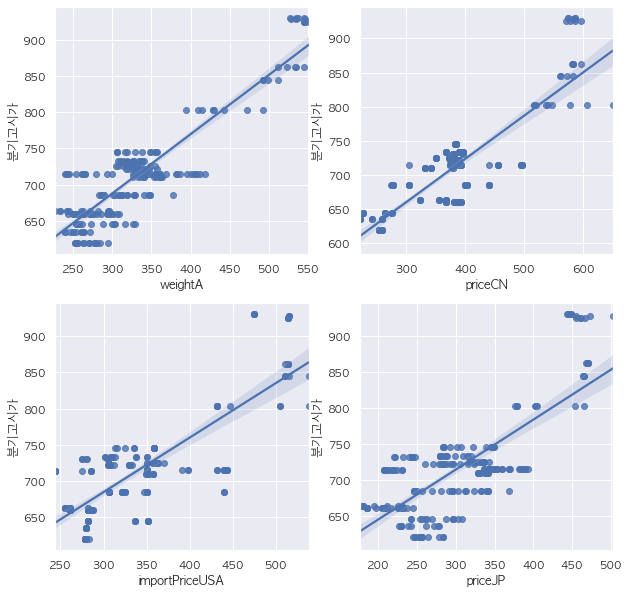

In [326]:
plt.figure(figsize = (10,10))
for idx, col in enumerate(plot_cols[1:]):
    ax1= plt.subplot(2,2,idx+1)
    sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1)
plt.show()


# 차트를 통한 타당성 확인
## 분기가 아닌 위클리로 구하기 위해, 분기내 스크랩 변동폭이 5%이상일 경우, 실시간 반영하는 '분기별 스크랩가 평균'을 기반으로 공식을 적용함.
## 스크랩가 정의: 국내스크랩(중량A)70% + 일본(H2) 20% + USA(대형-벌크) 10%

In [327]:
# 계산을 위해 YEAR-Quarter 컬럼 추가 (값 형태 year.quarter)
df['quarter'] = df['date'].dt.year+ (df.date.dt.quarter)*0.1
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000


In [328]:
display(df.tail())

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter
242,2017-02-03,620,264.0000,244.0000,253.0000,253.7000,279.0000,245.0000,1007.0000,1149.0000,1015.0100,2017.1000
243,2017-01-27,620,270.0000,255.0000,255.0000,253.4000,279.0000,250.0000,1019.0000,1162.5000,1022.4300,2017.1000
244,2017-01-20,620,270.0000,251.0000,256.0000,253.4000,279.0000,270.0000,944.0000,1174.0000,1021.0600,2017.1000
245,2017-01-13,620,280.0000,251.0000,257.0000,253.4000,279.0000,280.0000,846.0000,1175.0000,1023.7900,2017.1000
246,2017-01-06,620,295.0000,253.0000,254.0000,253.4000,283.0000,280.0000,869.0000,1193.5000,1027.2900,2017.1000


In [329]:
#부서 고유공식(1) 적용된 스크랩가 구하기
df['scrap'] = df['weightA']*0.7 + df['importPriceJP']*0.2 + df['importPriceUSA']*0.1
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000,540.7000
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000,530.0000
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000,512.1000
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000,507.4000
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000,513.0000


In [330]:
df_a = df.groupby(['quarter'])['분기고시가'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()
df_b.head()

,quarter,scrap
0,2017.1000,271.5769
1,2017.2000,256.0583
2,2017.3000,293.2846
3,2017.4000,326.9667
4,2018.1000,347.8077


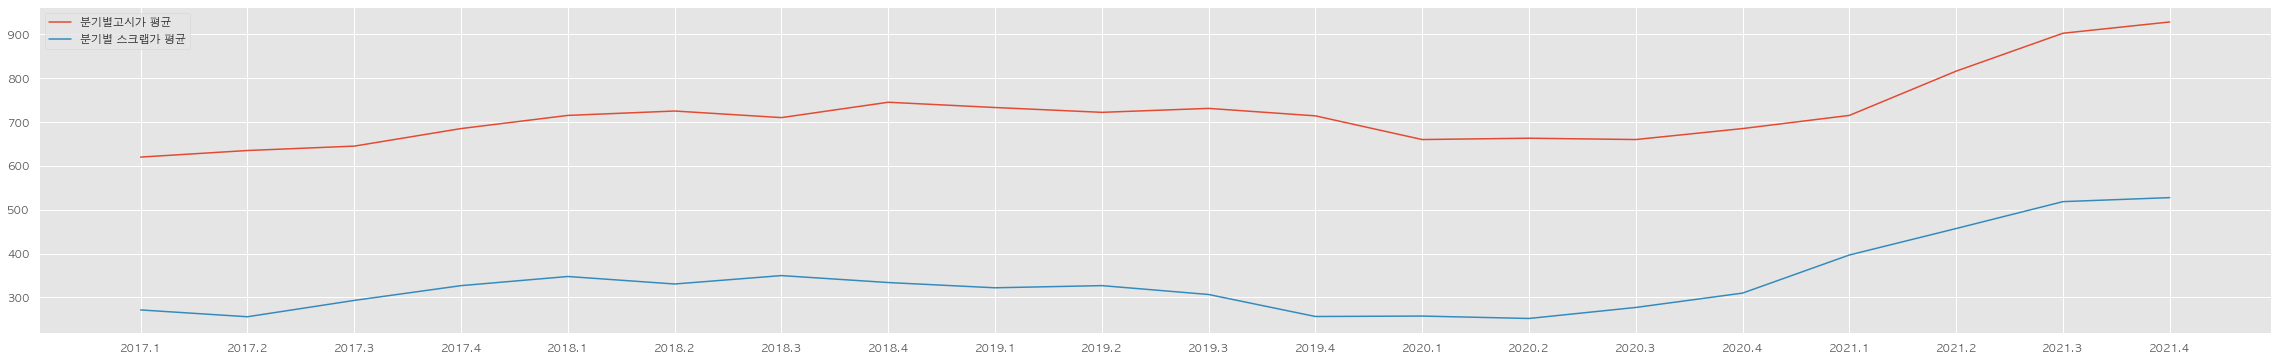

In [331]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df_a)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df_a.index, df_a['분기고시가'], label = '분기별고시가 평균')
ay.plot(df_b.index, df_b['scrap'] , label = '분기별 스크랩가 평균')
plt.xticks(xi, df_a['quarter'])
plt.legend() 

plt.show()

fig.savefig('./result_img/fig1.png', dpi = 100)
#fig.close()

In [183]:
# 차트에서와 같이 이전 분기의 스크랩평균가(파란선)가 그 다음 '분기별 고시가' 평균 (빨간선)을 어느정도 앞서는 것을 확인할 수 있음

In [332]:
#분기처리를 위한 배열
mr = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]

for m in mr:
    print(m)

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]


In [333]:
# 부서 요청사항: 스크랩평균가를 공식에 활용하여 철근의 분기(Quarter)고시가를 (Week)주기 고시가를 구하고(부서 고유공식 2), 3개월 뒤를 예측하는 모델

In [334]:
def get_quarter(m):
    if m >= 1 and m <= 3:
        return 1
    elif m >= 4 and m <= 6:
        return 2
    elif m >= 7 and m <= 9:
        return 3
    elif m >= 10 and m <= 12:
        return 4
print(get_quarter(3))

1


In [335]:
def get_sgap(row):
    month = row.month #current month
    year = row.year
    if month % 3 == 0 : # 3, 6, 9, 12
        # *9월 = (7, 8월의 스크랩평균가)의 평균가가 전분기 대비 5% +- 상관없이 변동되었을 때.
        #(같은 분기 7월) 고시가 + [(7, 8월의 스크랩평균가) - (전분기, 2분기 스크랩평균가)]
        df_year = df[df['date'].dt.year == year]
        mean1 = df_year[df_year['date'].dt.month == month - 1].scrap.mean()
        mean2 = df_year[df_year['date'].dt.month == month - 2].scrap.mean()
        scrap_mean = (mean1 + mean2) / 2
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['분기고시가'].values[0]
        q1 = get_quarter(month) - 1
        if q1 == 0:
            year = year - 1
            q1 = 4
        try:
            previous_q1_mean_scrap = df_b[df_b.quarter == year + q1 * 0.1]['scrap'].values[0]
                       
            return same_quarter_price+ (scrap_mean - previous_q1_mean_scrap)
        except IndexError:
            return -1

    elif month % 3 == 1 : # 1 4 7 10
        # 7월 =전분기의 고시가인 4월 고시가 + [ 4,5,6(2분기) 스크랩 평균가  - 1분기 스크랩평균가 ] ​
        q1 = get_quarter(month) - 1
        previous_q1_mean_scrap = 0
        previous_q2_mean_scrap = 0
        previous_quarter_price = 0
        try:  
            previous_quarter_price  = df[df.quarter == year+0.1*(row.quarter-1)][-1:]['분기고시가'].values[0]
        except IndexError:
            previous_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['분기고시가'].values[0]
        try:  
            if q1 == 0:
                year = year - 1
                q2 = 4
                q1 = 3
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
            elif q1 == 1: # 4 month, 
                print(month)
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']  
                year = year -1
                q2 = 4
            else:
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap'] 
                q2 = q1 - 1
            previous_q2_mean_scrap = df_b[df_b.quarter == (year+q2*0.1)]['scrap']
            print("%d-%d ( %d %d )"%(year, month, q1, q2))
            a = previous_q1_mean_scrap.values[0]
            b = previous_q2_mean_scrap.values[0]
            if len(previous_q1_mean_scrap) > 0 and len(previous_q2_mean_scrap) > 0 :
                return previous_quarter_price + (a - b)
            else: return -1
        except TypeError:  
            return -2
        except Exception:
            return -3
    else : # 2 5 8 11
        # *8월 = 7월의 스크랩평균가가 전분기 대비 5% 변동되었을 경우,
        #(같은 분기의 7월) 고시가 + [( 7월 스크랩 평균가 ) -(전분기, 2분기 스크랩평균가) ]
        df_year = df[df['date'].dt.year == year]
        mean1 =  df_year[df_year['date'].dt.month == month-1 ].scrap.mean()
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['분기고시가'].values[0]
        q1 = get_quarter(month)-1        
        if q1 == 0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
        if len( previous_q1_mean_scrap.values) > 0:
            return same_quarter_price + (mean1 - previous_q1_mean_scrap.values)[0]
        else:
            return 0
df['scrap_gap'] = df['date'].apply(get_sgap)

2021-10 ( 3 2 )
2021-10 ( 3 2 )
2021-10 ( 3 2 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 

In [336]:
925.9013*0.05

46.295065

In [337]:
df

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap,scrap_gap
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000,540.7000,923.2923
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000,530.0000,923.2923
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000,512.1000,923.2923
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000,507.4000,925.9013
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000,513.0000,925.9013
5,2021-09-10,930,537.0000,453.0000,445.0000,586.0000,475.0000,450.0000,870.0000,1170.0000,1064.2700,2021.3000,513.4000,925.9013
6,2021-09-03,930,545.0000,443.0000,449.0000,574.0000,475.0000,455.0000,788.0000,1157.0000,1052.6300,2021.3000,520.0000,925.9013
7,2021-08-27,925,551.0000,442.0000,455.0000,571.0000,513.5000,450.0000,688.0000,1170.0000,1062.0900,2021.3000,527.0500,922.3738
8,2021-08-20,925,546.0000,441.0000,460.0000,577.0000,513.5000,450.0000,690.0000,1184.0000,1079.3100,2021.3000,523.5500,922.3738
9,2021-08-13,925,545.0000,435.0000,461.0000,586.0000,513.5000,455.0000,705.0000,1169.0000,1059.9800,2021.3000,523.8500,922.3738


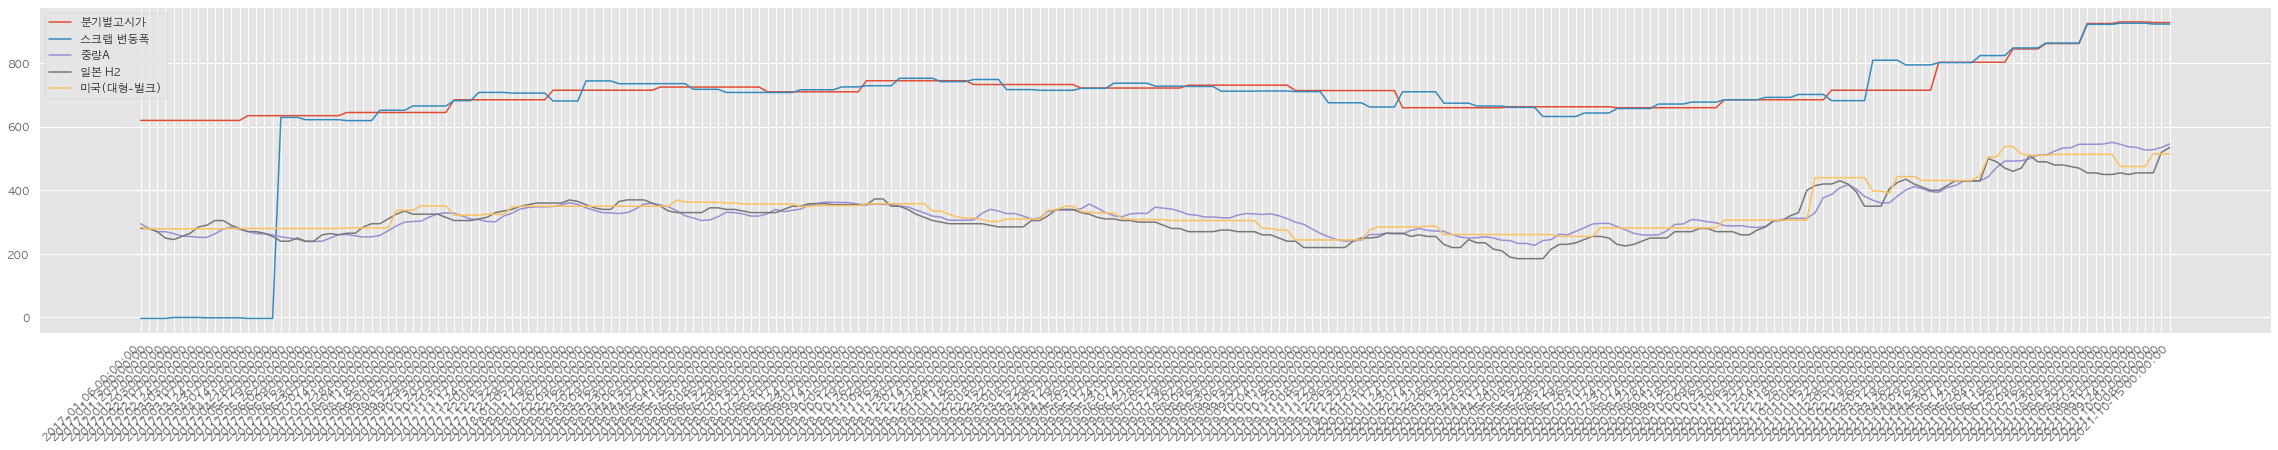

In [338]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()

fig.savefig('./result_img/fig2.png', dpi = 100)

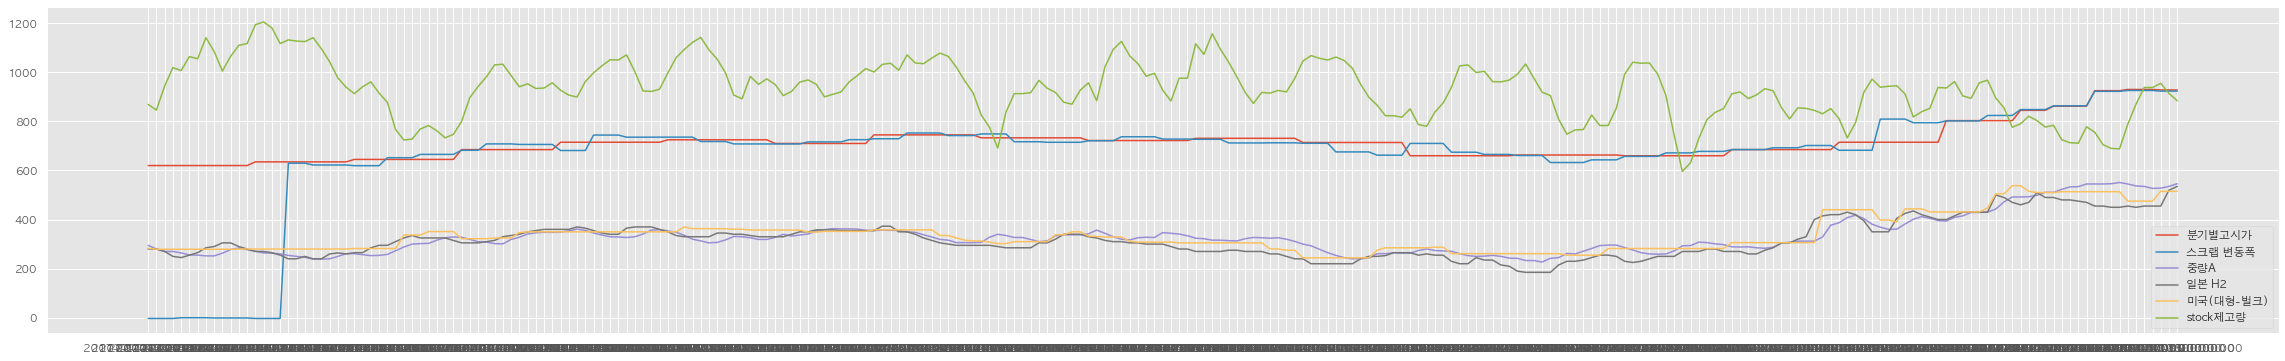

In [340]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

ay.plot(df.index, df['stock'], label = "stock제고량")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()

fig.savefig('./result_img/fig3.png', dpi = 100)


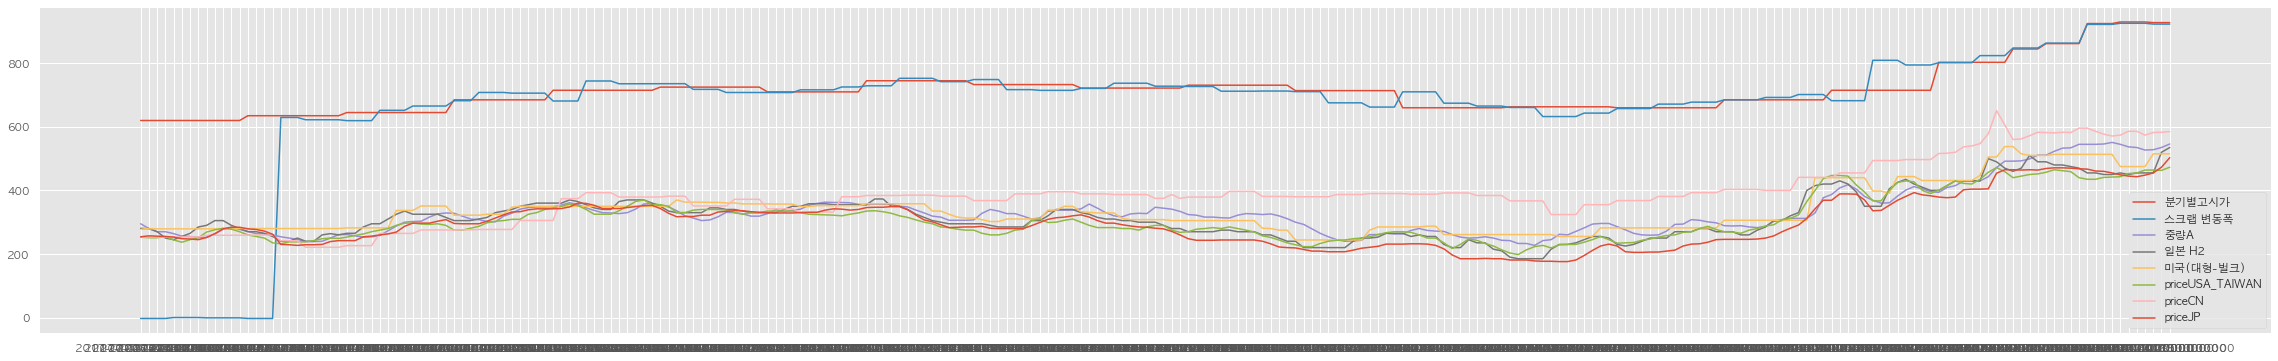

In [341]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

ay.plot(df.index, df['priceUSA_TAIWAN'], label = "priceUSA_TAIWAN")
ay.plot(df.index, df['priceCN'], label = "priceCN")
ay.plot(df.index, df['priceJP'], label = "priceJP")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()

fig.savefig('./result_img/fig4.png', dpi = 100)

In [342]:
from prophet import Prophet
import pandas as pd

In [343]:
# df['stock'] 국내 철강사 제고량이 시계열 특성을 가지고 있으므로 prophet으로 시황성 자제 제고를 예측
df_for_p = pd.DataFrame()
df_for_p['ds'] = df['date']
df_for_p['y'] = df['stock']
df_for_p['cap']= 1500
df_for_p['floor'] = 650
#이상치 제거 , 650원 미만은
df_for_p.loc[df_for_p['y']<650, 'y'] = None
df_for_p

,ds,y,cap,floor
0,2021-10-15,884.0000,1500,650
1,2021-10-08,914.0000,1500,650
2,2021-10-01,955.0000,1500,650
3,2021-09-24,938.0000,1500,650
4,2021-09-17,938.0000,1500,650
5,2021-09-10,870.0000,1500,650
6,2021-09-03,788.0000,1500,650
7,2021-08-27,688.0000,1500,650
8,2021-08-20,690.0000,1500,650
9,2021-08-13,705.0000,1500,650


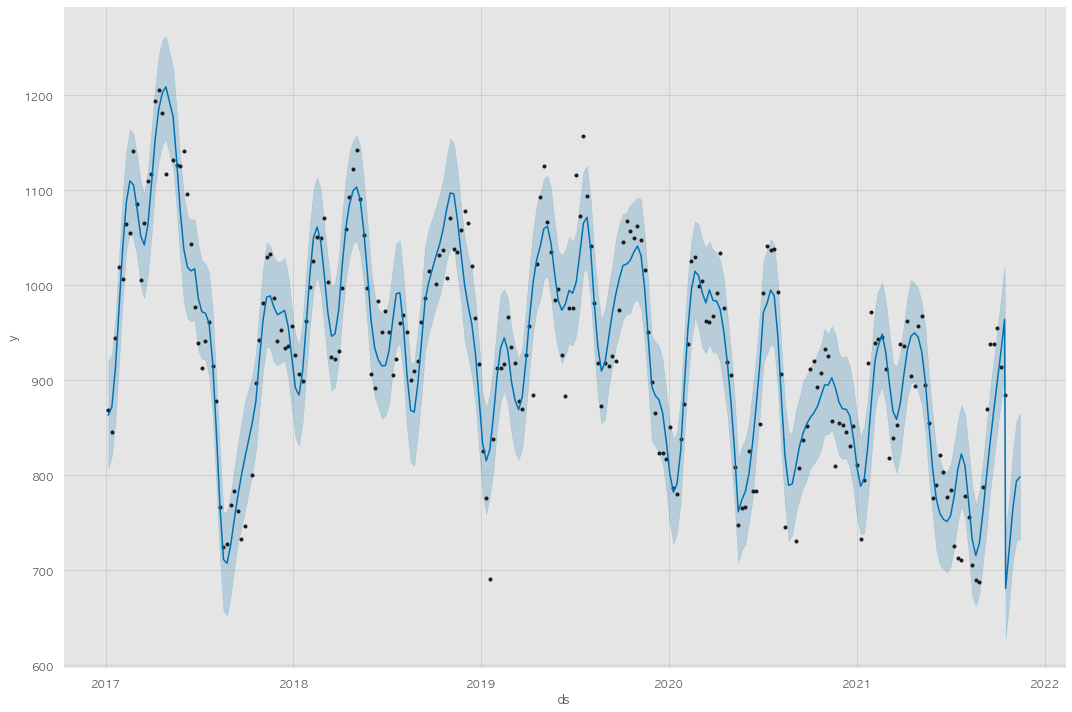

In [344]:
# prophet 모델을 학습
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(df_for_p)
#5주 예측
future_data = prophet.make_future_dataframe(periods=5, freq='w')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data, figsize = (15,10)) 

fig.savefig('./result_img/fig_prophet01.png', dpi = 100)

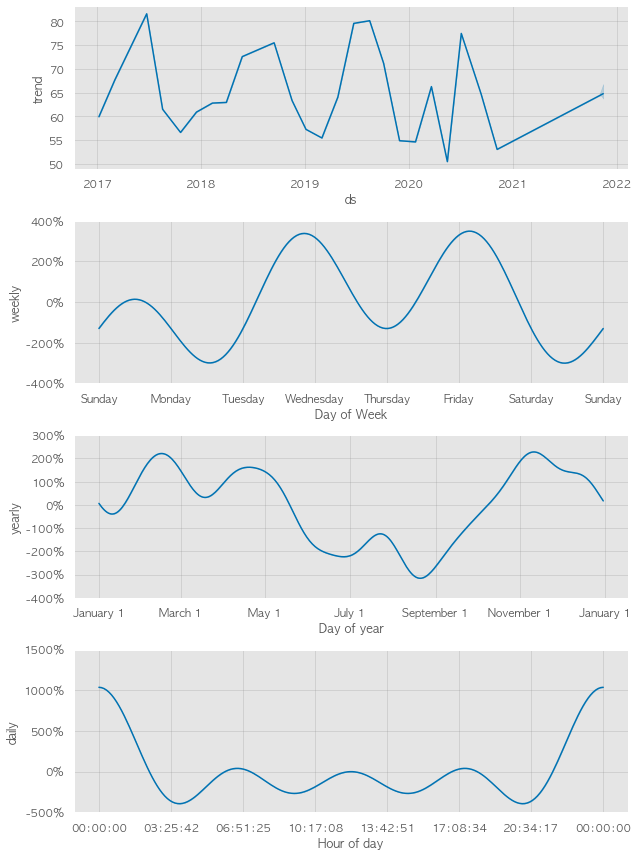

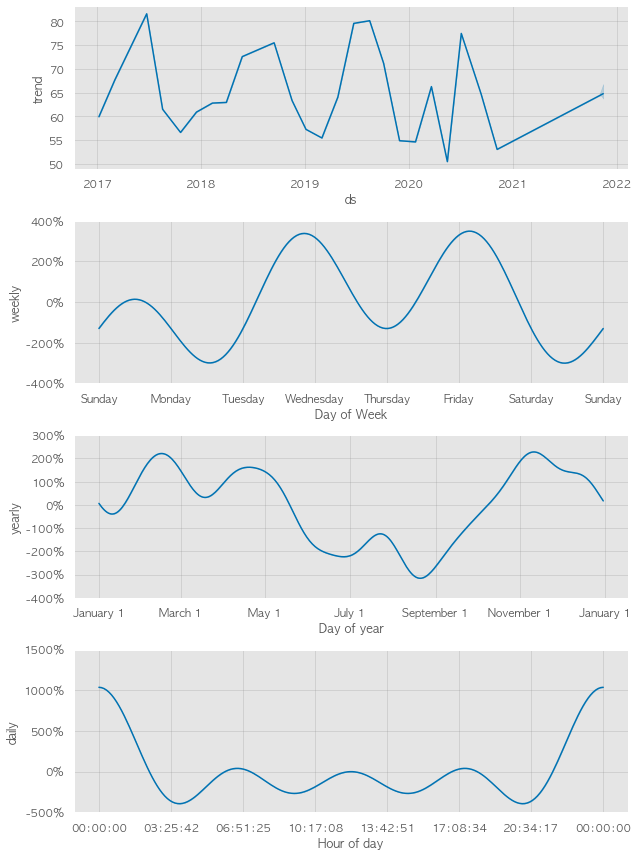

In [345]:
prophet.plot_components(forecast_data)



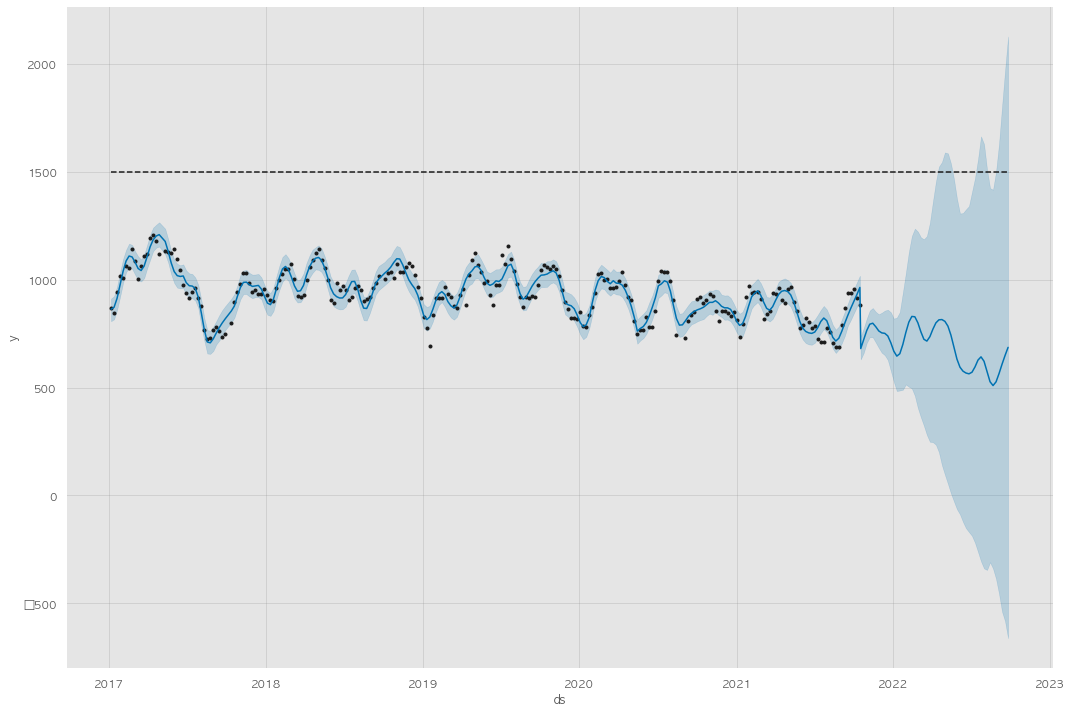

In [346]:
# 50주 이후를 예측
future_data = prophet.make_future_dataframe(periods=50, freq='w')
#상,하한가 제한
future_data['cap'] = 1500
future_data['floor'] = 650
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data ,  figsize=(15, 10)) 

fig.savefig('./result_img/fig_prophet02.png', dpi = 100)

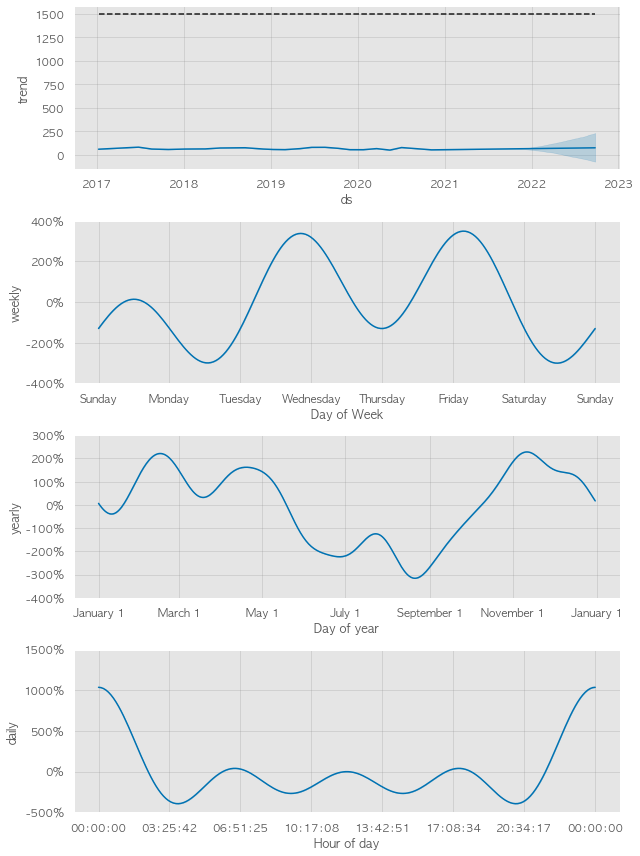

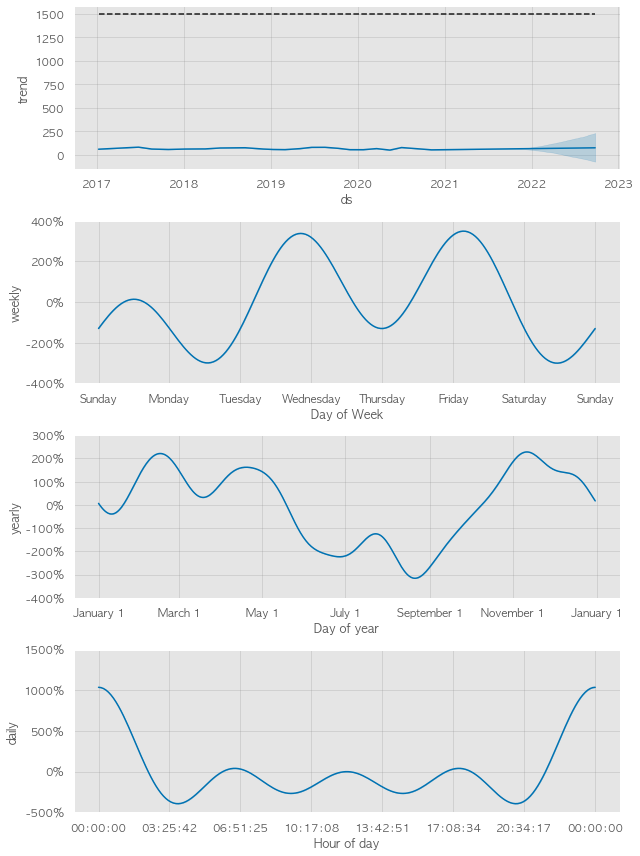

In [347]:
prophet.plot_components(forecast_data)

In [348]:
forecast_data


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-06,59.9285,1500,807.6123,912.3714,59.9285,59.9285,10.3733,10.3733,10.3733,13.4016,13.4016,13.4016,3.3053,3.3053,3.3053,-0.2770,-0.2770,-0.2770,0.0000,0.0000,0.0000,863.0646
1,2017-01-13,60.8984,1500,816.4834,923.3528,60.8984,60.8984,10.3733,10.3733,10.3733,13.3224,13.3224,13.3224,3.3053,3.3053,3.3053,-0.3561,-0.3561,-0.3561,0.0000,0.0000,0.0000,872.2133
2,2017-01-20,61.8682,1500,860.3098,968.4214,61.8682,61.8682,10.3733,10.3733,10.3733,13.7668,13.7668,13.7668,3.3053,3.3053,3.3053,0.0882,0.0882,0.0882,0.0000,0.0000,0.0000,913.5947
3,2017-01-27,62.8381,1500,921.2105,1032.8659,62.8381,62.8381,10.3733,10.3733,10.3733,14.5260,14.5260,14.5260,3.3053,3.3053,3.3053,0.8474,0.8474,0.8474,0.0000,0.0000,0.0000,975.6221
4,2017-02-03,63.8079,1500,985.8485,1095.7212,63.8079,63.8079,10.3733,10.3733,10.3733,15.2801,15.2801,15.2801,3.3053,3.3053,3.3053,1.6015,1.6015,1.6015,0.0000,0.0000,0.0000,1038.7992
5,2017-02-10,64.7778,1500,1035.3120,1138.3297,64.7778,64.7778,10.3733,10.3733,10.3733,15.7757,15.7757,15.7757,3.3053,3.3053,3.3053,2.0972,2.0972,2.0972,0.0000,0.0000,0.0000,1086.6955
6,2017-02-17,65.7477,1500,1055.5284,1167.0404,65.7477,65.7477,10.3733,10.3733,10.3733,15.8791,15.8791,15.8791,3.3053,3.3053,3.3053,2.2006,2.2006,2.2006,0.0000,0.0000,0.0000,1109.7623
7,2017-02-24,66.7175,1500,1050.9595,1160.9627,66.7175,66.7175,10.3733,10.3733,10.3733,15.5700,15.5700,15.5700,3.3053,3.3053,3.3053,1.8914,1.8914,1.8914,0.0000,0.0000,0.0000,1105.5074
8,2017-03-03,67.6874,1500,1023.7646,1131.7644,67.6874,67.6874,10.3733,10.3733,10.3733,14.9678,14.9678,14.9678,3.3053,3.3053,3.3053,1.2893,1.2893,1.2893,0.0000,0.0000,0.0000,1080.8210
9,2017-03-10,68.5567,1500,997.3471,1107.9098,68.5567,68.5567,10.3733,10.3733,10.3733,14.3449,14.3449,14.3449,3.3053,3.3053,3.3053,0.6663,0.6663,0.6663,0.0000,0.0000,0.0000,1051.9931


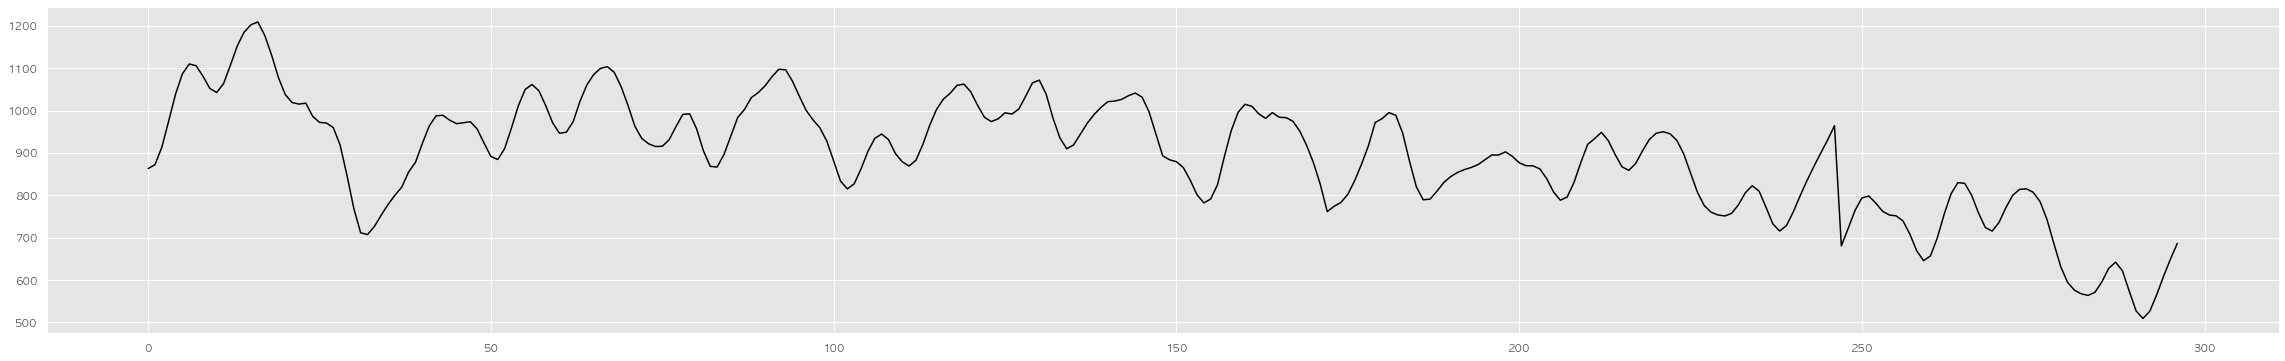

In [201]:
plt.plot(forecast_data.yhat, color="black")


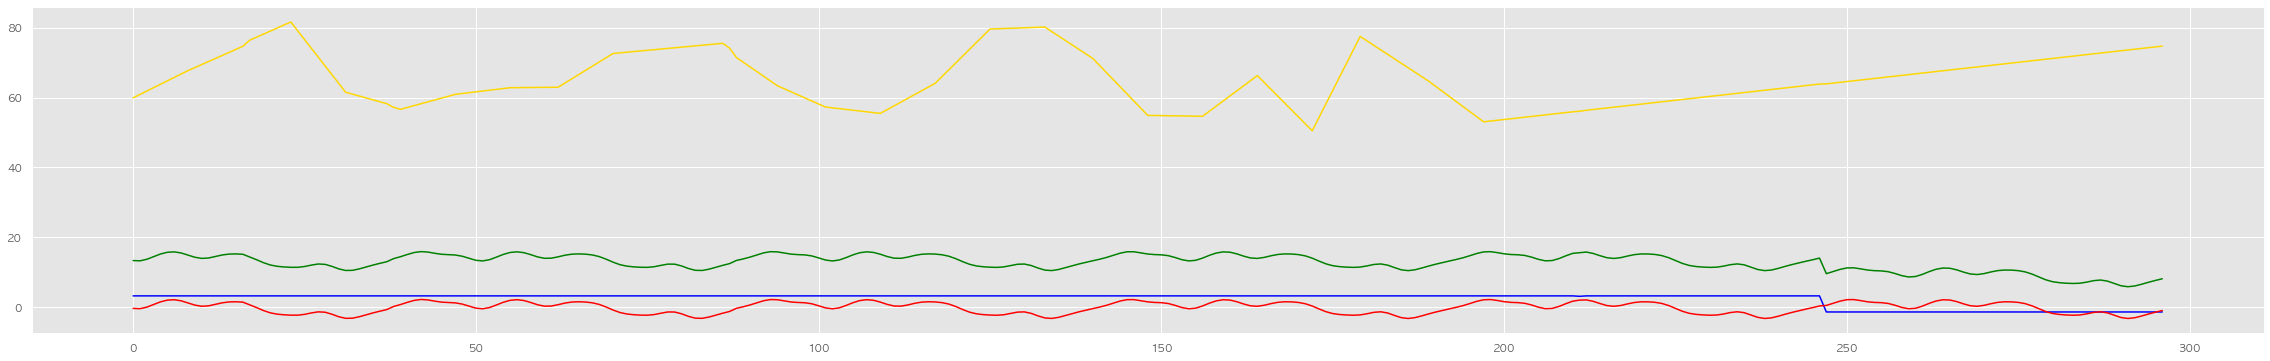

In [202]:
plt.plot(forecast_data.trend, color="gold")
plt.plot(forecast_data.multiplicative_terms, color="green")
plt.plot(forecast_data.weekly, color="blue")
plt.plot(forecast_data.yearly, color="red")




In [349]:
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap,scrap_gap
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000,540.7000,923.2923
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000,530.0000,923.2923
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000,512.1000,923.2923
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000,507.4000,925.9013
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000,513.0000,925.9013


In [353]:
aa= df[["date", "분기고시가","weightA","priceJP","priceCN","importPriceUSA","importPriceJP"]]
aa.to_csv("./data/aa.csv", index=False)

In [204]:
df_predict_data = df[df['scrap_gap']>100]
df_predict_data.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap,scrap_gap
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000,540.7000,923.2923
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000,530.0000,923.2923
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000,512.1000,923.2923
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000,507.4000,925.9013
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000,513.0000,925.9013


In [317]:
df['forecast']= forecast_data.multiplicative_terms
df

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap,scrap_gap,forecast
0,2021-10-15,0.9935,0.9846,1.0000,1.0000,0.8465,0.9218,1.0000,0.4729,0.6732,0.4454,1.0000,1.0000,0.9972,13.4016
1,2021-10-08,0.9935,0.9506,0.9636,0.9083,0.8419,0.9218,0.9571,0.5222,0.7151,0.6019,1.0000,0.9664,0.9972,13.3224
2,2021-10-01,0.9935,0.9290,0.9673,0.8532,0.8395,0.9218,0.7714,0.5895,0.6899,0.5553,1.0000,0.9103,0.9972,13.7668
3,2021-09-24,1.0000,0.9259,0.9673,0.8318,0.8209,0.7857,0.7714,0.5616,0.6229,0.6015,0.9767,0.8955,1.0000,14.5260
4,2021-09-17,1.0000,0.9506,0.9345,0.8165,0.8488,0.7857,0.7714,0.5616,0.6201,0.6217,0.9767,0.9131,1.0000,15.2801
5,2021-09-10,1.0000,0.9568,0.9273,0.8226,0.8488,0.7857,0.7571,0.4499,0.6006,0.5818,0.9767,0.9143,1.0000,15.7757
6,2021-09-03,1.0000,0.9815,0.8909,0.8349,0.8209,0.7857,0.7714,0.3153,0.5279,0.5275,0.9767,0.9350,1.0000,15.8791
7,2021-08-27,0.9839,1.0000,0.8873,0.8532,0.8140,0.9167,0.7571,0.1511,0.6006,0.5716,0.9767,0.9572,0.9962,15.5700
8,2021-08-20,0.9839,0.9846,0.8836,0.8685,0.8279,0.9167,0.7571,0.1544,0.6788,0.6520,0.9767,0.9462,0.9962,14.9678
9,2021-08-13,0.9839,0.9815,0.8618,0.8716,0.8488,0.9167,0.7714,0.1790,0.5950,0.5618,0.9767,0.9471,0.9962,14.3449


In [298]:
#Feature scaling
#ScikitLearn의 MinxMax Scaler를 이용한 정규화(Normalization)
#min,max = 0~1

df_s = df.loc[:, [col for col in df.columns if col != "scrap_gap"]]
#df_s = df#df[df['scrap_gap']>100]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled= df_s.iloc[:, 1:] # col date remove

In [299]:
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)
df_s.iloc[:, 1:] = df_scaled[:, :]

In [300]:

df_s

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap,forecast
0,2021-10-15,0.9935,0.9846,1.0000,1.0000,0.8465,0.9218,1.0000,0.4729,0.6732,0.4454,1.0000,1.0000,0.5298
1,2021-10-08,0.9935,0.9506,0.9636,0.9083,0.8419,0.9218,0.9571,0.5222,0.7151,0.6019,1.0000,0.9664,0.5152
2,2021-10-01,0.9935,0.9290,0.9673,0.8532,0.8395,0.9218,0.7714,0.5895,0.6899,0.5553,1.0000,0.9103,0.5970
3,2021-09-24,1.0000,0.9259,0.9673,0.8318,0.8209,0.7857,0.7714,0.5616,0.6229,0.6015,0.9767,0.8955,0.7367
4,2021-09-17,1.0000,0.9506,0.9345,0.8165,0.8488,0.7857,0.7714,0.5616,0.6201,0.6217,0.9767,0.9131,0.8754
5,2021-09-10,1.0000,0.9568,0.9273,0.8226,0.8488,0.7857,0.7571,0.4499,0.6006,0.5818,0.9767,0.9143,0.9667
6,2021-09-03,1.0000,0.9815,0.8909,0.8349,0.8209,0.7857,0.7714,0.3153,0.5279,0.5275,0.9767,0.9350,0.9857
7,2021-08-27,0.9839,1.0000,0.8873,0.8532,0.8140,0.9167,0.7571,0.1511,0.6006,0.5716,0.9767,0.9572,0.9288
8,2021-08-20,0.9839,0.9846,0.8836,0.8685,0.8279,0.9167,0.7571,0.1544,0.6788,0.6520,0.9767,0.9462,0.8180
9,2021-08-13,0.9839,0.9815,0.8618,0.8716,0.8488,0.9167,0.7714,0.1790,0.5950,0.5618,0.9767,0.9471,0.7033


In [301]:
#weightA            0.8965
#priceCN            0.8447
#importPriceUSA     0.7994
#priceJP            0.7713
#priceUSA_TAIWAN    0.7607

In [302]:
predict_data = df_s
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
#X = predict_data[["priceUSA_TAIWAN","priceJP","priceCN","importPriceUSA","importPriceJP" , "USD_KR","JYP_KR",forecast_data.multiplicative_terms]]
X = predict_data[["weightA","priceUSA_TAIWAN","priceJP","priceCN","importPriceUSA","importPriceJP","USD_KR","JPY_KR","forecast"]]
#X = predict_data[["priceJP","priceCN","importPriceUSA"]]#,forecast_data.multiplicative_terms]]


In [308]:
#모델에 기여하는 변수를 확인

y = df["분기고시가"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
#coef['coeffiecient_abs'] =coef['coefficient'].abs()
res_coef1 = coef.sort_values(by ='coefficient', ascending=False)
res_coef1


0.8791171821301647
0.9068640484883569


,feature_names,coefficient
0,weightA,0.8214
3,priceCN,0.6316
2,priceJP,0.2086
6,USD_KR,0.1597
8,forecast,0.0414
1,priceUSA_TAIWAN,0.0301
4,importPriceUSA,-0.2027
7,JPY_KR,-0.3377
5,importPriceJP,-0.5914


In [304]:
y = df["scrap_gap"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
#모델에 기여하는 변수를 확인
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
#coef['coeffiecient_abs'] =coef['coefficient'].abs()
res_coef = coef.sort_values(by ='coefficient', ascending=False)
res_coef


0.5363613028864906
0.16566246542821483


,feature_names,coefficient
0,weightA,0.7849
4,importPriceUSA,0.6850
3,priceCN,0.6805
5,importPriceJP,0.3918
8,forecast,0.1427
7,JPY_KR,0.1013
6,USD_KR,-0.5811
1,priceUSA_TAIWAN,-0.6600
2,priceJP,-1.3757


In [315]:

df.to_csv("normalized_df.csv", index=False)
res_coef.to_csv("coef_result.csv",index=False)
res_coef1.to_csv("coef.csv",index=False)

In [256]:
x1 = [0.9, 0.92, 0.94, 0.9, 0.94, 0.96, 0.96,0.95, 0.99]
x2 = [0.7, 0.6, 0.6,  0.9, 0.94, 0.96, 0.96,0.95, 0.99]
x_pred = [x1, x2]
model.predict(x_pred)
#uselog_months.to_csv("use_log_months.csv",index=False)

array([0.8331, 1.226 ])